# Observations, data acquisition, data analysis 
## High-contrast imaging
### Author
D. Ségransan
### Date
May 28, 2021
### Goals
Here you will study and reduce the high contrat images taken on two multiple stars, namely Gl909 and Gl494 observed at both the Canada-France-Hawaii telescope with the PUEO adaptive optics instrument  (Gl909 & Gl494) and with the NIRC2 instrument at KECK (Gl909).<br>
For each instrument, you will : <br>
 - Describe the observing strategy <br>
 - Study and reduce the calibration files to obtain the detector gain map and badpixel map <br>
 - Process the science frames to obtain : <br>
     - a cube of **clean** images <br>
     - a single **high signal to noise** image<br>
 - Derive the binary star parameters (separation, position angle and flux ratio). <br>


### Requirements
Python 3 with numpy, matplotib and astropy.
jupyter or jupyter-lab is recommended.


# STEP 1 - Download files  GJ909A
You can retrieve the the three sets of observations at : <br>
https://drive.switch.ch/index.php/s/G5qxW8xUrW211rn for GJ909A (PUEO@CFHT) <br>
- Dark File : '643879o.fits'
- Dome Flats : '6479\[57-62]f.fits'
- Science Frames : '64792\[1-5]o.fits'


Information about the PUEO detector can be found here : 
https://www.cfht.hawaii.edu/Instruments/Detectors/IR/KIR/index.html

#  STEP 2 - QuickLook at the images and observing strategy 
## Use of DS9 to highlight features in the raw images
Load the images into DS9. <br>
From the top menu, choose :
 - **File** and select ***Display Header***. Describe and categorize the image you are dealing, *ie.* type of image, format, filter (and observing wavelength), exposure time, date, MJD, Time (UT) and Airmass.<br> 
 - **Scale** and select ***scale parameters***. Set the min/max values according to the histogram of the image flux. Write down the filename you are looking at and the the values you have choosen. Change scales to ***log, lin, sqrt***. Make screenshots and attach them to the notebook and describe what you are looking at.<br>
 - **Color** and select, ***grey, heat, cool, i8***. You can also ***invert*** each of the color map. Same a above, make a screenshot and provide a very short description.<br>
 - **Analysis** and select,   ***contours*** and ***grid*** to improve the localisation of the features in the images. Same a above, make a screenshot and provide a very short description.<br>
 - **Frame** and select,   ***cube*** and browse trough the individual frames of the image cube of the *f.fits and *o.fits files. Describe what you are looking at. Pay a special attention to the *o.fits files<br>

Describe the observing strategy that was chosen by the observer and  make an ***educated guess*** on the use you will make of these different files.

# STEP 3 -  Gain map & Bad pixel map  from the Flats
You should have noticed from the image quicklook analysis that the detector has a significant number of bad pixels. Such pixels should be identified and flagged in a ***bad pixel map***. In addition, a ***detector gain map*** should be created to take into account the pixels' response that varies from pixel to pixel. These two steps are essential and must be done with care before conducting any *advanced* image analysis. Indeed, residual *bad pixels* our an incorrect estimate of the pixels' response could lead to serious biases in the determination of the position (astrometry) and flux (photometry) of the target(s) that  are  being  studied. 



#### Imports

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import sys,os,os.path
from astropy.io import fits
from astropy.stats import mad_std

#### This section of the practical makes use of the following functions/commands :
***Mandatory :*** <br>
hdul   = fits.open()<br>
hdul\[0].header<br>
hdul\[0].data<br>
hdul.close()<br>
<br>
fig,ax=plt.subplots()<br>
ax.hist()<br>
ax.imshow()<br>
ax.text()<br>
plt.savefig()<br>
<br>
image.flatten()<br>
np.mean()<br>
np.median()<br>
np.std()<br>
np.percentile()<br>
mad_std()<br><br>

## Dome Flats Statistics
Sequentially load the dome flats and collapse them along the z-axis by taking the 
- median
- mean

Store the values in two image cubes **flatMed** and **flatMean** of size **(Nflats,Nx,Ny)** where Nflats is the number falt fits-files taken with different exposure time, (Nx,Ny) is the size if the image.
Store also the values of the exposure time in an 1D array **flatExpTime** of size **(Nflats)**.

Estimate, for each pixel the flux disperion  along the z-axis using the :
- standard deviation (std)
- median absolute deviation (mad)

Store the values in two image cubes **flatStd** and **flatMad** of size **(Nflats,Nx,Ny)** 

Explain why the **median** and the **mad** are prefered - in some cases - to the **mean** and the **standard deviation** to estimate the first two moments of a distribution.

In the following part, you'll be working with flat images collapsed on the z-axis using the **median** and the **mad**.

Sort the collapsed dome flats according to their exposure time, flatten the 2D array and display their flux histograms. <br><br>
List the following **percentiles** for each of the flat **(0.5\%, 2.5\%, 5\%,25\% 50\%, 25\%, 5\%, 2.5\%,0.5\%)**<br>
<br>
Comment<br>

In [2]:
p1 = os.getcwd() + '/Data1/'
flt = ['647957f.fits', '647958f.fits', '647959f.fits', '647960f.fits', '647961f.fits', '647962f.fits']

hdul = fits.open(p1 + flt[0])
h1 = hdul[0].data
hhe = hdul[0].header
#print(hhe['inttime'])

# Exposure time
flatExpTime = np.zeros(len(flt))
for i in range(len(flt)):
    hh = fits.open(p1 + flt[0])
    hh1 = hh[0].header
    flatExpTime[i] = hh1['inttime']

In [3]:
mean0 = np.mean(h1, axis=0)
med0 = np.median(h1, axis=0)
std0 = np.std(h1, axis=0)
mad0 = mad_std(h1, axis=0)

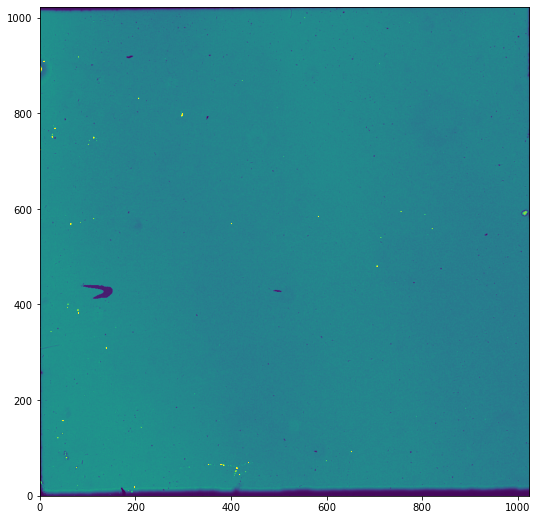

In [4]:
plt.figure(figsize=(9,9))
plt.imshow(med0, origin='lower', vmin=1, vmax=7000)

In [6]:
flatMed1 = np.array(med0)
flatMean1 = np.array(mean0)
flatStd1 = np.array(std0)
flatMad1 = np.array(mad0)

for i in range(len(flt)-1):
    hdl = fits.open(p1 + flt[i+1])
    hd1 = hdl[0].data
    flatMed1 = np.dstack((flatMed1, np.median(hd1, axis=0)))
    flatMean1 = np.dstack((flatMed1, np.mean(hd1, axis=0)))
    flatStd1 = np.dstack((flatStd1, np.std(hd1, axis=0)))
    flatMad1 = np.dstack((flatMad1, mad_std(hd1, axis=0)))

flatMed = np.transpose(flatMed1)
flatMean = np.transpose(flatMean1)
flatStd = np.transpose(flatStd1)
flatMad = np.transpose(flatMad1)

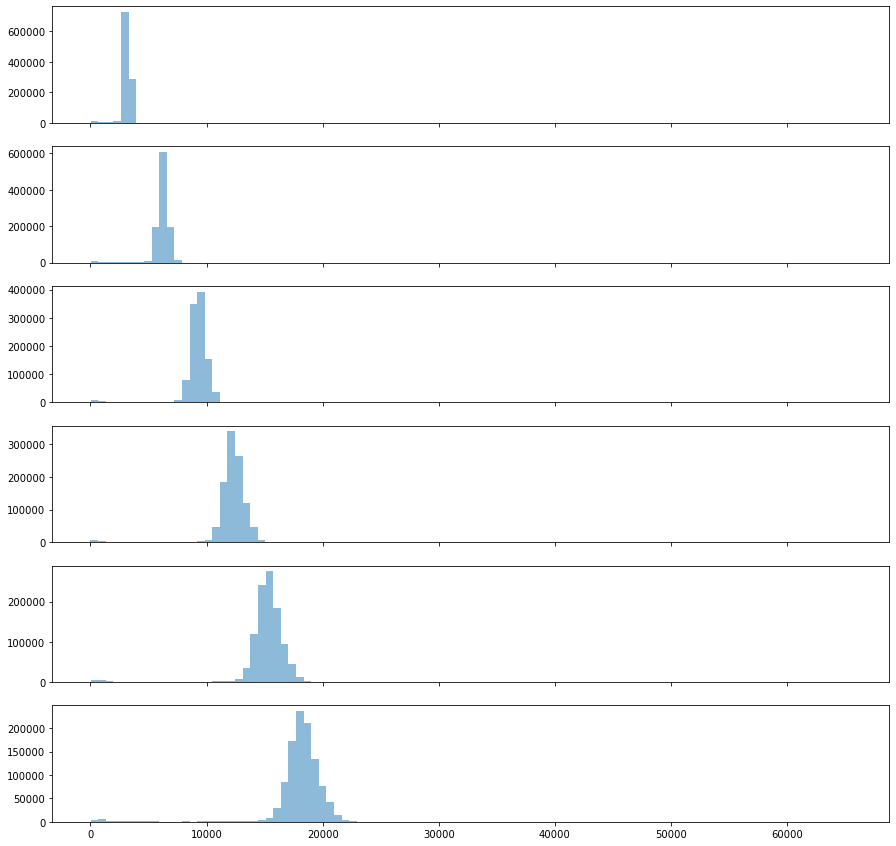

In [7]:
fig,axs = plt.subplots(len(flt), 1, sharex=True, figsize=(15, 15))
for i in range(len(flt)):
    axs[i].hist(flatMed[i,:,:].flatten(), bins=100, alpha=0.5)

## Gain map & Bad pixel map
You'll be using the **flatMed**  and **flatMad** cubes generated before to create the detector's **bad pixel map** and **gain map**.
To do so, you'll estimate the response of each pixel to linear increase in flux by performing a linear regression along the  z-axis (exposure time), *where*  : <br>
- t = flatExpTime     : size (Nflats)
- y = flatMed\[:,i,j]  :  size (Nflats)
- yerr :      size (Nflats)

The errors on ***y*** can be estimated using :
- the detector readout value of sigDet = 5AU for each exposure 
- the pixel photon noise 

***Beware*** that we have already averaged the original cubes. It does impact the estimate of both the photon and detector noise. By which amount ?<br>
*Hint:* How many frames are present in the original *f.fits cubes ?

Provide here an estimate of yerr.

Check your results for several pixels of coordinates (i,j):

In [9]:
i,j=200,150
for k in range(0,6):
    print('%4.0f   %8.1f  %6.1f  %6.1f'%(flatExpTime[k],flatMed[k,i,j],
                                         flatMad[k,i,j],yerr))

NameError: name 'yerr' is not defined

### Linear regression - a short recap
Let's consider a set of *N* observations $\boldsymbol{y}$ with uncorrelated error bars $\boldsymbol{\sigma}$ which can modeled with a linear model composed of M parameteres such that : <br>
$\boldsymbol{f} = \boldsymbol{X}.\boldsymbol{a}$  where $\boldsymbol{X}$ is a matrix of size *(N,M)* and  $\boldsymbol{a}$ a vector of size *M*.<br><br>
Let's make the following change of variables  $\boldsymbol{b}=\boldsymbol{y}/\boldsymbol{\sigma}$,  $\boldsymbol{A}=\boldsymbol{X}/\boldsymbol{\sigma}$ and  write the
*chi-square* as $\chi^2 = (\boldsymbol{b}-\boldsymbol{A}.\boldsymbol{a})^T.(\boldsymbol{b}-\boldsymbol{A}.\boldsymbol{a})$.  Here  $\boldsymbol{A}$ is called the ***designed matrix***.<br>

Minimizing the $\chi^2$ is easily done and results in a set of M equations with M unkwnowns called the  ***normal equation*** written : <br>
$\boldsymbol{A}^T.\boldsymbol{b}=\boldsymbol{A}^T.\boldsymbol{A}.\boldsymbol{a}$<br>

Solving the normal equation  for $\boldsymbol{a}$ leads to $\boldsymbol{a}=(\boldsymbol{A}^T.\boldsymbol{A})^{-1} . \boldsymbol{A}^T.\boldsymbol{b}$ where $\boldsymbol{C}= (\boldsymbol{A}^T.\boldsymbol{A})^{-1}$ is called the ***covariance matrix***.<br>

The diagonal elements of  $\boldsymbol{A}$ are the variances of the adjusted parameters  $\boldsymbol{a}$  and
correspond to the squared uncertainties (or squared standard deviation) of the adjusted parameters $\boldsymbol{a}$, *ie.*  $\sigma^2(a_i) = C_{i,i}$. The off-diagonal elements of $C_{j,k}, j \neq k$ are the covariances between $a_j$ and $a_k$.

In [10]:
def leastsq(A,b):
    #solve normal equation  a = C.At.b
    alpha= np.dot(A.T, A)
    beta = np.dot(A.T, b)
    C = np.linalg.inv(alpha)
    a = np.dot(C,beta)
    r = b-np.dot(A,a)
    chi2 = np.dot(r.T,r)
    
    return  a,C,chi2

def fitStraightLine(y, yerr, texp):
    #create designed Matrix of a straight line model
    #and solve the normal equation for a 
    X=np.vstack([texp, np.ones(len(texp))]).T
    b=y/yerr
    A=X/yerr[:,np.newaxis]
    return leastsq(A,b)

In [15]:
s=np.zeros((hhe['NAXIS1'],hhe['NAXIS2']))
s_std=np.zeros((hhe['NAXIS1'],hhe['NAXIS2']))
chi2=np.zeros((hhe['NAXIS1'],hhe['NAXIS2']))
#
detRon=5
flatErr=np.sqrt(flatMed/6 + detRon**2/6)

for i in range(0,hhe['NAXIS1']):
    for j in range(0,hhe['NAXIS2']):
        r = fitStraightLine(flatMed[:,i,j], flatErr[:,i,j], flatExpTime)
        s[i,j]=r[0][0]
        s_std[i,j]=np.sqrt(r[1][0,0])
        chi2[i,j]=r[2]

ipykernel_launcher:12: RuntimeWarning: invalid value encountered in sqrt


#### Computing the Gain Map
You can either use the  ***fitStraightLine*** or your favourite python package to perform the linear regression.

You will create here 3 maps of size (Nx,Ny) which contain:
- the *reduced chi-square* values
- the fitted slope values
- the errors on the fitted slope
- the gain map

***Remark :*** The *gain map* is estimated by dividing the *slope map*  by its median value.

Display each of the map (imshow) with an adequate color map/scale

Flatten each of the 2D array and display their histograms. 

List the following percentiles for each map (0.5%, 2.5%, 5%,25% 50%, 25%, 5%, 2.5%,0.5%)

**Comment your results :**

**More advanced Question :** How would you estimate if the detector has a non-linear response ? How would you model it and correct for it?

/home/jayshil/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jayshil/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


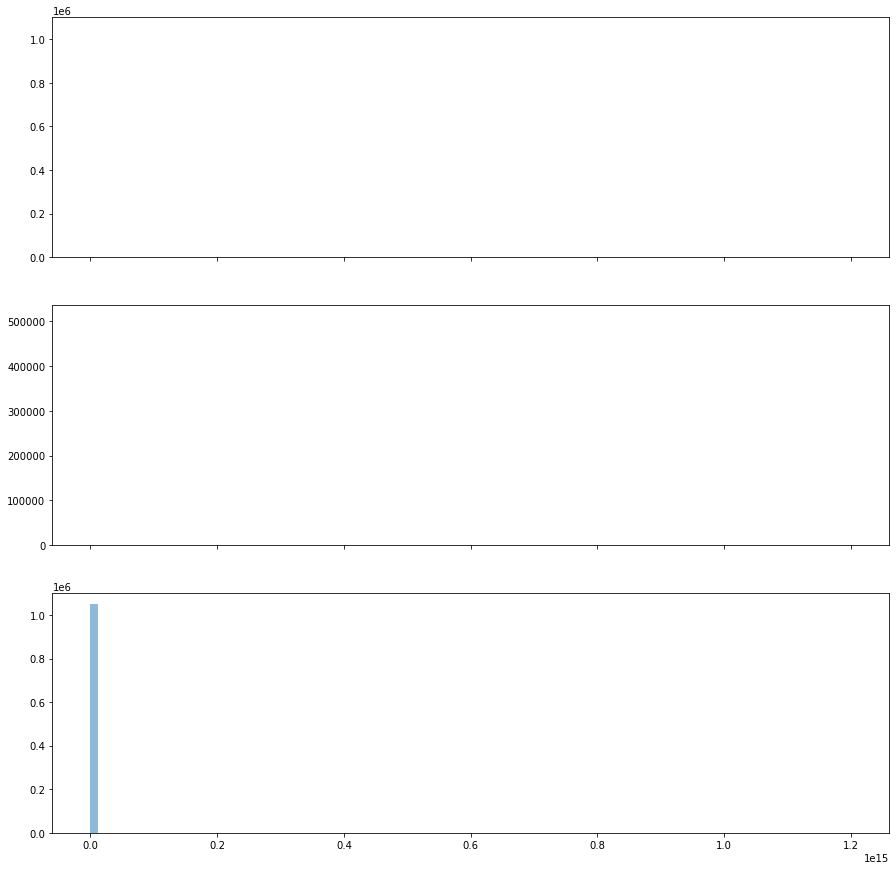

In [20]:
fig,axs = plt.subplots(3, 1, sharex=True, figsize=(15, 15))
axs[0].hist(s.flatten(), bins=100, alpha=0.5)
axs[1].hist(s_std.flatten(), bins=100, alpha=0.5)
axs[2].hist(chi2.flatten(), bins=100, alpha=0.5)
plt.show()

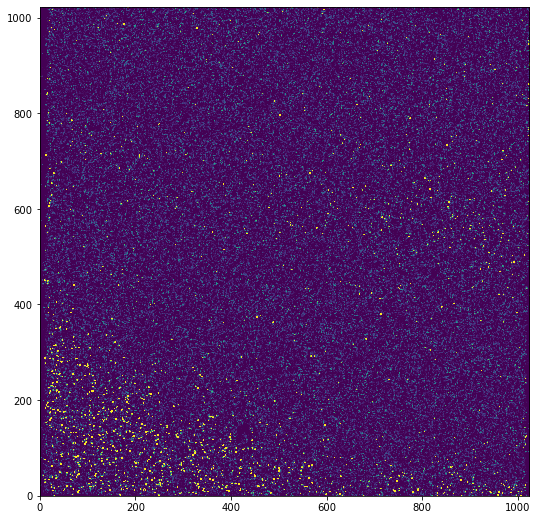

In [18]:
gain_map = s/np.median(s)
plt.figure(figsize=(9,9))
plt.imshow(gain_map, origin='lower', vmin=1, vmax=30)

#### Creating the  bad pixel Map
Pixels are tagged as *bad* when their *gain* lies outside a given initerval. 
- Give the interval for which pixels can be considered as bad.
- Provide possible additional criteria to flag bad pixels.
- Create several bad pixel maps, display and compare them.

# STEP 4 -  Load and calibrate the science images

Now that you have  generated the detector gain map and a bad pixel map, you can create a  fully calibrated image
imc=(im-background)/gain




 



# STEP 5 -  Separation, orientation  and flux ratio of the binary star.


# STEP 6 -  Combining the 5 sequences of images into a  single high signal to noise image

